In [1]:
#IMPORT Libraries
import pandas as pd
import numpy as np
import math
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from IPython.display import display

In [4]:
# create a dataframe for the pipe data. This is done bases on my local files, but need to aligned to the final result of the Feature Engineering and Data Cleaning
#point to the folder where the data is stored for Diana
os.chdir(r"C:\Users\dianaf\OneDrive\IE\Datathon") 

df_network = pd.read_csv("df_submission1.csv") #909733 rows - test data set

df_inspection = pd.read_csv("inspections.csv") #6345344 rows - inspection data set

df = pd.merge(df_inspection, df_network, on="PipeId")

In [5]:
#define the sample size we run through for the comparison. Need to find a way to do it thru all the data set

df_cost = df.iloc[73:10073]


In [6]:
df_cost.shape

(10000, 18)

# BASELINE COST CALCULATION

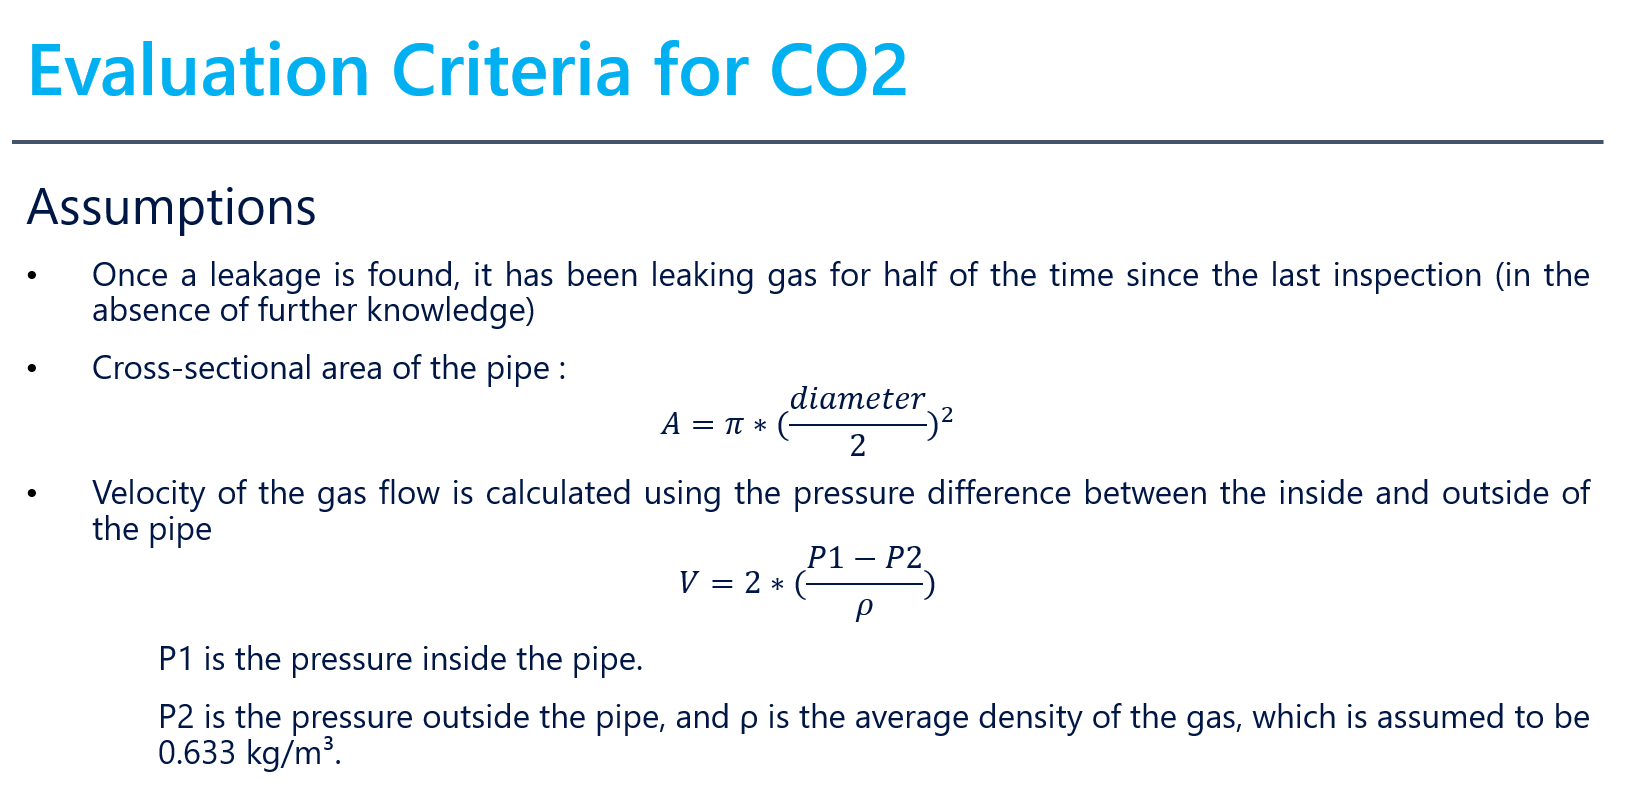

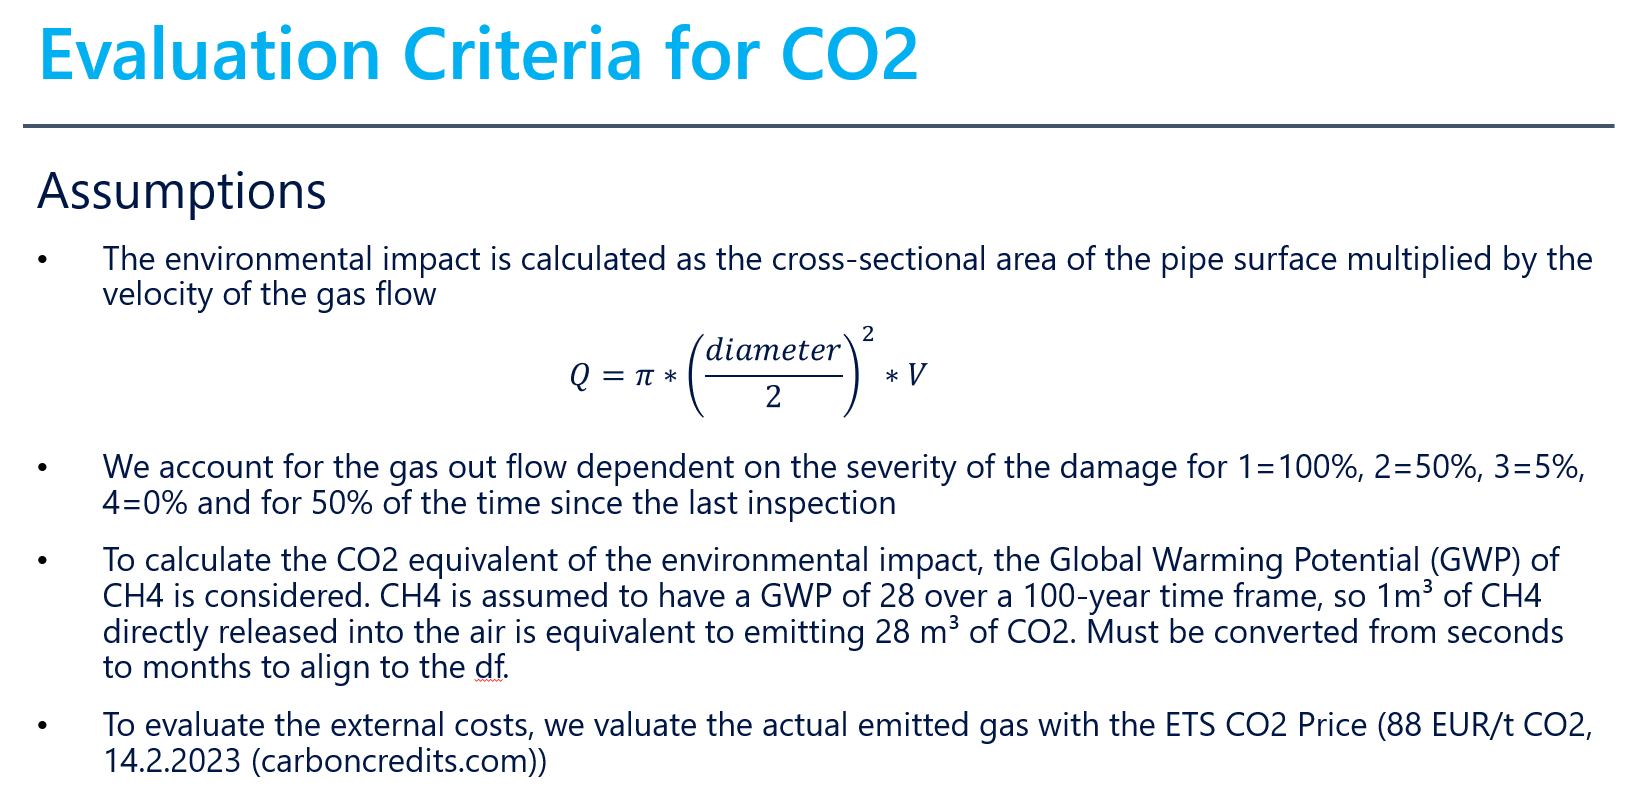

In [5]:
# Formula for Environmental Impact 


df_cost['b_Co2'] = np.where(df_cost['Severity'] == 1, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633* df_cost['MonthsLastRev']*0.5*2629800*28*1*88,
                            np.where(df_cost['Severity'] == 2, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633* df_cost['MonthsLastRev']*0.5*2629800*28*0.5*88,
                            np.where(df_cost['Severity'] == 3, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633* df_cost['MonthsLastRev']*0.5*2629800*28*0.05*88,
                            np.where(df_cost['Severity'] == 4, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633* df_cost['MonthsLastRev']*0.5*2629800*28*0*88, np.nan))))
df.head()


,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,b_Co2
73,188889938,ZRV-00001406,2011,2011-11-17,13,4,0,Barcelona,Barcelona,1999,PE,Gas natural,160.0,77.024,0.025,5,0,False,0.000000
74,188889938,ZRV-00001406,2013,2013-11-12,24,4,0,Barcelona,Barcelona,1999,PE,Gas natural,160.0,77.024,0.025,5,0,False,0.000000
75,188889938,ZRV-00001406,2015,2015-11-06,24,3,1,Barcelona,Barcelona,1999,PE,Gas natural,160.0,77.024,0.025,5,0,False,61.746283
76,188889938,ZRV-00001406,2017,2017-11-23,24,4,0,Barcelona,Barcelona,1999,PE,Gas natural,160.0,77.024,0.025,5,0,False,0.000000
77,188889938,ZRV-00001406,2019,2019-11-21,24,4,0,Barcelona,Barcelona,1999,PE,Gas natural,160.0,77.024,0.025,5,0,False,0.000000


############### WORK IN PROGRESS#########################

In [6]:
# sum costs for baseline scenario
results = pd.DataFrame()

#efficiency measure - time between failure and detection - expressed as sum of days of malfunctioning hardware

df['InspectionDate'] = pd.to_datetime(df['InspectionDate'], format='%Y-%m-%d')
df['LastInspect'] = df['InspectionDate'] - pd.TimedeltaIndex(df['MonthsLastRev'], unit='h')
df['b_timedifference']=(df['InspectionDate']-df['LastInspect']).dt.total_seconds()/(24*60*60*30) 

results['b_timedifference'] = df.groupby("InspectionYear").sum()["b_timedifference"]

# failure costs
results['b_failure_costs'] = df.groupby("InspectionYear").sum()["b_Co2"]

# inspection costs // per length
df['b_insp_costs'] = df['Length']*3.2 # based on https://www.researchgate.net/publication/284228211_Stochastic_modelling_of_perfect_inspection_and_repair_actions_for_leak-failure_prone_internal_corroded_pipelines#pf13
results['b_insp_costs'] = df.groupby("InspectionYear").sum()["b_insp_costs"]

# total costs
results['b_total_costs'] = results['b_failure_costs'] + results['b_insp_costs']

results


,b_timedifference,b_failure_costs,b_insp_costs,b_total_costs
InspectionYear,,,,
2010,50.176389,14165.119809,189496.2560,203661.375809
2011,5.019444,714.122289,30591.7440,31305.866289
2012,41.027778,34626.605011,162155.5264,196782.131411
2013,14.404167,0.000000,67574.3296,67574.329600
2014,33.716667,9315.198551,125891.2608,135206.459351
2015,19.981944,796.189370,67272.8064,68068.995770
2016,32.297222,6966.200000,126107.7440,133073.944000
2017,19.911111,0.000000,67798.7712,67798.771200
2018,33.276389,6924.347115,125976.4384,132900.785515


# Parameter Set for Optimized Scenarios 

In [7]:
#import the probabilities for failure occurance from prediction model
mean = 0.5
std = 0.1

df['random_variable'] = np.random.normal(mean, std, df.shape[0])

df.head()

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,...,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,b_Co2,LastInspect,b_timedifference,b_insp_costs,random_variable
73,188889938,ZRV-00001406,2011,2011-11-17,13,4,0,Barcelona,Barcelona,1999,...,77.024,0.025,5,0,False,0.000000,2011-11-16 11:00:00,0.018056,246.4768,0.369009
74,188889938,ZRV-00001406,2013,2013-11-12,24,4,0,Barcelona,Barcelona,1999,...,77.024,0.025,5,0,False,0.000000,2013-11-11 00:00:00,0.033333,246.4768,0.708727
75,188889938,ZRV-00001406,2015,2015-11-06,24,3,1,Barcelona,Barcelona,1999,...,77.024,0.025,5,0,False,61.746283,2015-11-05 00:00:00,0.033333,246.4768,0.808215
76,188889938,ZRV-00001406,2017,2017-11-23,24,4,0,Barcelona,Barcelona,1999,...,77.024,0.025,5,0,False,0.000000,2017-11-22 00:00:00,0.033333,246.4768,0.833411
77,188889938,ZRV-00001406,2019,2019-11-21,24,4,0,Barcelona,Barcelona,1999,...,77.024,0.025,5,0,False,0.000000,2019-11-20 00:00:00,0.033333,246.4768,0.626994


In [8]:
# The optimization runs through week by week from start_date to end_date and selects those pipes with the most likely failure.  


# 1st: we have to define Parameters for the discreet optimization model for scenario centralized and decentralized


start_date_str = "2010-01-01"
end_date_str = "2020-12-31"

start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.strptime(end_date_str, '%Y-%m-%d')


# 2nd: set the number of inspected pipes per week for each iteration

num_selected = 20



#3rd: we evaluate every inspection based on CO2 costs which evolove due to leaking gas. df['fco2'] is the factor we multiply with the time of leakage


df['fco2'] = np.where(df['Severity'] == 1, (df['Diameter']/2/1000)**2 * np.pi * df['Pressure'] * 2 / 100000 / 0.633*0.5*2629800*28*1*88,
                            np.where(df['Severity'] == 2, (df['Diameter']/2/1000)**2 * np.pi * df['Pressure'] * 2 / 100000 / 0.633*0.5*2629800*28*0.5*88,
                            np.where(df['Severity'] == 3, (df['Diameter']/2/1000)**2 * np.pi * df['Pressure'] * 2 / 100000 / 0.633*0.5*2629800*28*0.05*88,
                            np.where(df['Severity'] == 4, (df['Diameter']/2/1000)**2 * np.pi * df['Pressure'] * 2 / 100000 / 0.633*0.5*2629800*28*0*88, np.nan))))
#                                                                       π * (D/2)²                            v=2 * (P1 - P2)                    / ρ                    *             CH4 potential * percentage severity * CO2 price
#      EUR                                                                  m2                  mm/m   *           m/s             /  bar/kPsc   / kg/m³                *                   t/m³       * []              * EUR/t
#

# reformate inspection date and lastInspect for datetime 
df['InspectionDate'] = pd.to_datetime(df['InspectionDate'], format='%Y-%m-%d')
df['LastInspect'] = df['InspectionDate'] - pd.TimedeltaIndex(df['MonthsLastRev']*4, unit='W')



In [9]:
df['fco2'].head(80)


73     0.000000
74     0.000000
75     2.572762
76     0.000000
77     0.000000
         ...   
148    0.000000
149    0.000000
150    0.000000
151    0.000000
152    0.000000
Name: fco2, Length: 80, dtype: float64

# decentralized scenario


In [10]:
#calculation of the costs for failure, with a focus on the environmental costs for CO2

#d...    d scenario
#CO2...  costs for failure with a focus on CO2
#base... costs for inspection per km pipe

In [11]:
# Create Dataframes for decentralized optimization

df['d_random_variable']=df['random_variable'] # d_random varialbe is the random variable which changes through out the simulation. 

#prepare time indicators for evaluating the failure function

df['d_InspectionDate_op'] = pd.to_datetime(df['InspectionDate'], format='%Y-%m-%d')


df['LastInspect'] = df['InspectionDate'] - pd.TimedeltaIndex(df['MonthsLastRev'], unit='h')
df['d_timedifference'] = pd.to_timedelta(1, unit='D') #this variable evaluates how long the mal supply took

#formatting all dates for datetime


#Create variable for the costs for mal supply and emitting CO2 into the atomosphere // external costs
df['d_failure_costs'] = 0 




In [12]:
timedelta= end_date-start_date
timedelta


datetime.timedelta(days=4017)

In [13]:
# Run through the optimization for the decentralized approach


pbar = tqdm(total=(end_date - start_date).days // 7)

# STEP 0: Create a loop structure to go through week by week
for date in pd.date_range(start_date, end_date, freq='W'):
    
     # STEP 1: Take the highest 250 values of df['d_random_variable']
     # select the top num_selected rows based on prediction input =(random variable)

        df_sorted = df.sort_values('d_random_variable', ascending=False).iloc[:num_selected]
    
    # STEP2: Add inspection date

        df.loc[df_sorted.index, 'd_InspectionDate_op'] = date
       # df.loc[df_sorted.index, 'd_InspectionDate_op'] = df_sorted['d_InspectionDate_op'].copy() 
        


    # STEP 3: Failure and Cost Valuation
    
        df_sorted['d_timedifference'] =  (df_sorted['d_InspectionDate_op']-df_sorted['LastInspect']).dt.total_seconds()/(24*60*60*30) 
        df_sorted['d_timedifference'] =  np.maximum(df_sorted['d_timedifference'], 0) #the max function insures, that if the last inspection in the data took place after the optimized inspection, that it is 0 and nonnegative
        df.loc[df_sorted.index, 'd_timedifference'] = df_sorted['d_timedifference'].copy() 
       
    
        df_sorted['d_failure_costs'] =  df_sorted['d_timedifference'] *df_sorted['fco2']
        df.loc[df_sorted.index, 'd_failure_costs'] = df_sorted['d_failure_costs'].copy() 
        
        
        df_sorted['d_InspectionDate_op'] = df_sorted['d_InspectionDate_op'].dt.strftime('%Y-%m-%d')
        
        df.loc[df_sorted.index, 'd_InspectionDate_op'] = df_sorted['d_InspectionDate_op'].values
        
        
   # STEP 4: Set back df['d_random_variable']

# 0.5  is an assumption that the risk for another failure is set off by 50% after inspection and repair
        
        df_sorted['d_random_variable'] =  df_sorted['d_random_variable']*0.5 
        df.loc[df_sorted.index, 'd_random_variable'] = df_sorted['d_random_variable'].copy()

        
        # Update the progress bar

        pbar.update() # assuming we're iterating through weeks
        
       



100%|███████████████████████████████████████████████████████████████████████████████▋| 571/573 [00:14<00:00, 46.06it/s]

In [14]:
df['InspectionDate']

73      2011-11-17
74      2013-11-12
75      2015-11-06
76      2017-11-23
77      2019-11-21
           ...    
10068   2016-03-30
10069   2017-04-06
10070   2018-02-21
10071   2019-12-11
10072   2020-12-14
Name: InspectionDate, Length: 10000, dtype: datetime64[ns]

In [15]:
df['d_InspectionDate_op']

73      2011-11-17
74      2013-11-12
75      2015-11-06
76      2017-11-23
77      2019-11-21
           ...    
10068   2016-03-30
10069   2017-04-06
10070   2018-02-21
10071   2019-12-11
10072   2020-12-14
Name: d_InspectionDate_op, Length: 10000, dtype: datetime64[ns]

In [17]:
df.to_csv('my_data.csv', index=False)


In [18]:
#writing an inspection year for scenario decentralized
df['d_inspection_year'] = df['d_InspectionDate_op'].dt.year
df

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,...,LastInspect,b_timedifference,b_insp_costs,random_variable,fco2,d_random_variable,d_InspectionDate_op,d_timedifference,d_failure_costs,d_inspection_year
73,188889938,ZRV-00001406,2011,2011-11-17,13,4,0,Barcelona,Barcelona,1999,...,2011-11-16 11:00:00,0.018056,246.4768,0.369009,0.000000,0.184504,2011-11-17,0.018056,0.000000,2011
74,188889938,ZRV-00001406,2013,2013-11-12,24,4,0,Barcelona,Barcelona,1999,...,2013-11-11 00:00:00,0.033333,246.4768,0.708727,0.000000,0.177182,2013-11-12,0.033333,0.000000,2013
75,188889938,ZRV-00001406,2015,2015-11-06,24,3,1,Barcelona,Barcelona,1999,...,2015-11-05 00:00:00,0.033333,246.4768,0.808215,2.572762,0.202054,2015-11-06,0.033333,0.085759,2015
76,188889938,ZRV-00001406,2017,2017-11-23,24,4,0,Barcelona,Barcelona,1999,...,2017-11-22 00:00:00,0.033333,246.4768,0.833411,0.000000,0.208353,2017-11-23,0.033333,0.000000,2017
77,188889938,ZRV-00001406,2019,2019-11-21,24,4,0,Barcelona,Barcelona,1999,...,2019-11-20 00:00:00,0.033333,246.4768,0.626994,0.000000,0.156749,2019-11-21,0.033333,0.000000,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10068,20670797,ZRV-00003733,2016,2016-03-30,9,4,0,Madrid,Madrid,1997,...,2016-03-29 15:00:00,0.012500,131.6416,0.202363,0.000000,0.202363,2016-03-30,1 days 00:00:00,0.000000,2016
10069,20670797,ZRV-00003734,2017,2017-04-06,13,4,0,Madrid,Madrid,1997,...,2017-04-05 11:00:00,0.018056,131.6416,0.484721,0.000000,0.242361,2017-04-06,0.018056,0.000000,2017
10070,20670797,ZRV-00003733,2018,2018-02-21,10,4,0,Madrid,Madrid,1997,...,2018-02-20 14:00:00,0.013889,131.6416,0.445982,0.000000,0.222991,2018-02-21,0.013889,0.000000,2018
10071,20670797,ZRV-00003733,2019,2019-12-11,22,4,0,Madrid,Madrid,1997,...,2019-12-10 02:00:00,0.030556,131.6416,0.447608,0.000000,0.223804,2019-12-11,0.030556,0.000000,2019


In [19]:
df.head()

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,...,LastInspect,b_timedifference,b_insp_costs,random_variable,fco2,d_random_variable,d_InspectionDate_op,d_timedifference,d_failure_costs,d_inspection_year
73,188889938,ZRV-00001406,2011,2011-11-17,13,4,0,Barcelona,Barcelona,1999,...,2011-11-16 11:00:00,0.018056,246.4768,0.369009,0.000000,0.184504,2011-11-17,0.018056,0.000000,2011
74,188889938,ZRV-00001406,2013,2013-11-12,24,4,0,Barcelona,Barcelona,1999,...,2013-11-11 00:00:00,0.033333,246.4768,0.708727,0.000000,0.177182,2013-11-12,0.033333,0.000000,2013
75,188889938,ZRV-00001406,2015,2015-11-06,24,3,1,Barcelona,Barcelona,1999,...,2015-11-05 00:00:00,0.033333,246.4768,0.808215,2.572762,0.202054,2015-11-06,0.033333,0.085759,2015
76,188889938,ZRV-00001406,2017,2017-11-23,24,4,0,Barcelona,Barcelona,1999,...,2017-11-22 00:00:00,0.033333,246.4768,0.833411,0.000000,0.208353,2017-11-23,0.033333,0.000000,2017
77,188889938,ZRV-00001406,2019,2019-11-21,24,4,0,Barcelona,Barcelona,1999,...,2019-11-20 00:00:00,0.033333,246.4768,0.626994,0.000000,0.156749,2019-11-21,0.033333,0.000000,2019


In [20]:
df ['d_timedifference']


73              0.018056
74              0.033333
75              0.033333
76              0.033333
77              0.033333
              ...       
10068    1 days 00:00:00
10069           0.018056
10070           0.013889
10071           0.030556
10072           0.016667
Name: d_timedifference, Length: 10000, dtype: object

In [21]:
# sum costs for decentralized scenario

#duration of malfunctioning

df['d_timedifference'] = df['d_timedifference'].apply(lambda x: int(x.days) if isinstance(x, pd.Timedelta) else x)
results['d_timedifference'] = df.groupby("d_inspection_year").sum()["d_timedifference"]


# failure costs
results['d_failure_costs'] = df.groupby("d_inspection_year").sum()["d_failure_costs"]

# inspection costs // per length
df['d_insp_costs'] = df['Length']*3.2 # based on https://www.researchgate.net/publication/284228211_Stochastic_modelling_of_perfect_inspection_and_repair_actions_for_leak-failure_prone_internal_corroded_pipelines#pf13

results['d_insp_costs'] = df.groupby("d_inspection_year").sum()["d_insp_costs"]

# total costs
results['d_total_costs'] = results['d_failure_costs'] + results['d_insp_costs']

results

,b_timedifference,b_failure_costs,b_insp_costs,b_total_costs,d_timedifference,d_failure_costs,d_insp_costs,d_total_costs
InspectionYear,,,,,,,,
2010,50.176389,14165.119809,189496.2560,203661.375809,91.883333,5.145758,189496.2560,189501.401758
2011,5.019444,714.122289,30591.7440,31305.866289,10.922222,0.991837,30591.7440,30592.735837
2012,41.027778,34626.605011,162155.5264,196782.131411,73.058333,46.824571,162155.5264,162202.350971
2013,14.404167,0.000000,67574.3296,67574.329600,23.258333,0.000000,67574.3296,67574.329600
2014,33.716667,9315.198551,125891.2608,135206.459351,53.086111,12.937776,125891.2608,125904.198576
2015,19.981944,796.189370,67272.8064,68068.995770,34.481944,1.105819,67272.8064,67273.912219
2016,32.297222,6966.200000,126107.7440,133073.944000,55.583333,8.407342,126107.7440,126116.151342
2017,19.911111,0.000000,67798.7712,67798.771200,32.484722,0.000000,67798.7712,67798.771200
2018,33.276389,6924.347115,125976.4384,132900.785515,53.643056,9.617149,125976.4384,125986.055549


# centralized scenario

In [22]:
# this is a restricted scenario, where the maintenance teams can only inspect pipes in one specific area of spain. 
# For that purpose we create a probability score indicator for the region to send out the maintenance team each week with highest score
# The teams are deployed in one region at a time and get´s redeployed to another region the next week 

In [23]:
# Create Dataframes for decentralized optimization

df['c_random_variable']=df['random_variable'] # d_random varialbe is the random variable which changes through out the simulation. 

#prepare time indicators for evaluating the failure function

df['c_InspectionDate_op'] = pd.to_datetime(df['InspectionDate'], format='%Y-%m-%d')


df['LastInspect'] = df['InspectionDate'] - pd.TimedeltaIndex(df['MonthsLastRev']*4, unit='h')
df['c_timedifference'] = pd.to_timedelta(1, unit='D') #this variable evaluates how long the mal supply took


#Create variable for the costs for mal supply and emitting CO2 into the atomosphere // external costs
df['c_failure_costs'] = 0 








In [24]:
#build a probility score for each region where the maintenance teams can operate within one timeperiode. 

prob_score=df.groupby("Province").sum()["random_variable"]
df['Prob_score']=1
df['Prob_score'] = df['Province'].map(prob_score)


In [25]:

# Run through the optimization for the centralized approach

#build a probility score for each region where the maintenance teams can operate within one timeperiode. 


df['Prob_score']=1   

#create a bar plot for the runntime
pbar = tqdm(total=(end_date - start_date).days // 7)

# STEP 0: Create a loop structure to go through week by week
for date in pd.date_range(start_date, end_date, freq='W'):
    
 # STEP 1: Create the regional probability score table
    

        prob_score=df.groupby("Province").sum()["c_random_variable"]
        
        df['Prob_score'] = df['Province'].map(prob_score)
        
        df_sorted = df.sort_values('Prob_score', ascending=False).iloc[:num_selected]

        
        
  # STEP2: Add inspection date

        df.loc[df_sorted.index, 'c_InspectionDate_op'] = date
        df.loc[df_sorted.index, 'c_InspectionDate_op'] = df_sorted['c_InspectionDate_op'].copy() 


  # STEP 3: Failure and Cost Valuation
    
        df_sorted['c_timedifference'] =  (df_sorted['c_InspectionDate_op']-df_sorted['LastInspect']).dt.total_seconds()/(24*60*60*30) 
        df_sorted['c_timedifference'] =  np.maximum(df_sorted['c_timedifference'], 0) #the max function insures, that if the last inspection in the data took place after the optimized inspection, that it is 0 and nonnegative
        df.loc[df_sorted.index, 'c_timedifference'] = df_sorted['c_timedifference'].copy() 
       
    
        df_sorted['c_failure_costs'] =  df_sorted['c_timedifference'] *df_sorted['fco2']
        df.loc[df_sorted.index, 'c_failure_costs'] = df_sorted['c_failure_costs'].copy() 
        
        
   # STEP 4: Set back df['c_random_variable']

        df_sorted['c_random_variable'] =  df_sorted['c_random_variable']*0.5 # 0.5  is an assumption that the risk for another failure is set off by 50% after inspection and repair
        df.loc[df_sorted.index, 'c_random_variable'] = df_sorted['c_random_variable'].copy()
         

        
        # Update the progress bar

        pbar.update()       
        
  
        
        
     


574it [03:49,  2.50it/s]                                                                       | 0/573 [00:00<?, ?it/s]

 34%|██████████████████████████▊                                                     | 192/573 [00:08<00:16, 22.86it/s]


 68%|██████████████████████████████████████████████████████▍                         | 390/573 [00:17<00:08, 22.72it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:25<00:00, 23.26it/s]

In [26]:
#writing an inspection year for scenario centralized
df['c_inspection_year'] = df['c_InspectionDate_op'].dt.year
df.head()
df.to_csv('my_data.csv', index=False)


In [27]:
# sum costs for decentralized scenario

#duration of malfunctioning

df['c_timedifference'] = df['c_timedifference'].apply(lambda x: int(x.days) if isinstance(x, pd.Timedelta) else x)
results['c_timedifference'] = df.groupby("c_inspection_year").sum()["c_timedifference"]
# failure costs
results['c_failure_costs'] = df.groupby("c_inspection_year").sum()["c_failure_costs"]

# inspection costs // per length
df['c_insp_costs'] = df['Length']*3.2 # based on https://www.researchgate.net/publication/284228211_Stochastic_modelling_of_perfect_inspection_and_repair_actions_for_leak-failure_prone_internal_corroded_pipelines#pf13
results['c_insp_costs'] = df.groupby("c_inspection_year").sum()["c_insp_costs"]

# total costs
results['c_total_costs'] = results['c_failure_costs'] + results['c_insp_costs']

results



,b_timedifference,b_failure_costs,b_insp_costs,b_total_costs,d_timedifference,d_failure_costs,d_insp_costs,d_total_costs,c_timedifference,c_failure_costs,c_insp_costs,c_total_costs
InspectionYear,,,,,,,,,,,,
2010,50.176389,14165.119809,189496.2560,203661.375809,91.883333,5.145758,189496.2560,189501.401758,1659.366667,0,189496.2560,189496.2560
2011,5.019444,714.122289,30591.7440,31305.866289,10.922222,0.991837,30591.7440,30592.735837,284.000000,0,30591.7440,30591.7440
2012,41.027778,34626.605011,162155.5264,196782.131411,73.058333,46.824571,162155.5264,162202.350971,1379.366667,0,162155.5264,162155.5264
2013,14.404167,0.000000,67574.3296,67574.329600,23.258333,0.000000,67574.3296,67574.329600,601.000000,0,67574.3296,67574.3296
2014,33.716667,9315.198551,125891.2608,135206.459351,53.086111,12.937776,125891.2608,125904.198576,1069.494444,0,125891.2608,125891.2608
2015,19.981944,796.189370,67272.8064,68068.995770,34.481944,1.105819,67272.8064,67273.912219,604.000000,0,67272.8064,67272.8064
2016,32.297222,6966.200000,126107.7440,133073.944000,55.583333,8.407342,126107.7440,126116.151342,1056.350000,0,126107.7440,126107.7440
2017,19.911111,0.000000,67798.7712,67798.771200,32.484722,0.000000,67798.7712,67798.771200,607.000000,0,67798.7712,67798.7712
2018,33.276389,6924.347115,125976.4384,132900.785515,53.643056,9.617149,125976.4384,125986.055549,1055.511111,0,125976.4384,125976.4384


In [28]:
total_cost_comparision = pd.DataFrame()

total_cost_comparision['b_total_costs'] = results['b_total_costs']
total_cost_comparision['c_total_costs'] = results['c_total_costs']
total_cost_comparision['d_total_costs'] = results['d_total_costs']

total_cost_comparision

,b_total_costs,c_total_costs,d_total_costs
InspectionYear,,,
2010,203661.375809,189496.2560,189501.401758
2011,31305.866289,30591.7440,30592.735837
2012,196782.131411,162155.5264,162202.350971
2013,67574.329600,67574.3296,67574.329600
2014,135206.459351,125891.2608,125904.198576
2015,68068.995770,67272.8064,67273.912219
2016,133073.944000,126107.7440,126116.151342
2017,67798.771200,67798.7712,67798.771200
2018,132900.785515,125976.4384,125986.055549


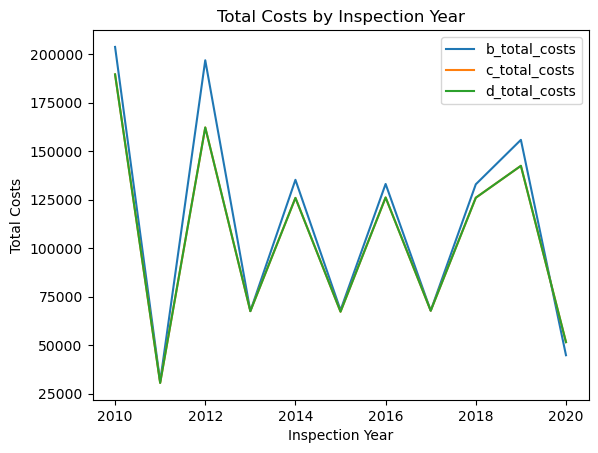

In [29]:
import matplotlib.pyplot as plt

# create the dataframe from the table
data = {'b_total_costs': total_cost_comparision['b_total_costs'],
        'c_total_costs': total_cost_comparision['c_total_costs'],
        'd_total_costs': total_cost_comparision['d_total_costs']}
df_p = pd.DataFrame(data, index=[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

# create the figure and axis objects
fig, ax = plt.subplots()

# plot the lines
df_p.plot(ax=ax)

# set the title and axis labels
ax.set_title('Total Costs by Inspection Year')
ax.set_xlabel('Inspection Year')
ax.set_ylabel('Total Costs')

# show the plot
plt.show()



In [30]:
efficiency_comparision = pd.DataFrame()

efficiency_comparision['b_timedifference'] = results['b_timedifference']
efficiency_comparision['c_timedifference'] = results['c_timedifference']
efficiency_comparision['d_timedifference'] = results['d_timedifference']

efficiency_comparision

,b_timedifference,c_timedifference,d_timedifference
InspectionYear,,,
2010,50.176389,1659.366667,91.883333
2011,5.019444,284.000000,10.922222
2012,41.027778,1379.366667,73.058333
2013,14.404167,601.000000,23.258333
2014,33.716667,1069.494444,53.086111
2015,19.981944,604.000000,34.481944
2016,32.297222,1056.350000,55.583333
2017,19.911111,607.000000,32.484722
2018,33.276389,1055.511111,53.643056



574it [00:40, 23.26it/s]                                                                                               